In [1]:
#!pip install pycocotools matplotlib

DEPRECATION: textract 1.6.5 has a non-standard dependency specifier extract-msg<=0.29.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of textract or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [2]:
import os

def print_directory_structure(root_dir):
    for dirpath, dirnames, _ in os.walk(root_dir):
        level = dirpath.replace(root_dir, '').count(os.sep)
        indent = ' ' * 4 * level
        print(f'{indent}{os.path.basename(dirpath)}/')

# Print directory structure for appliance dataset
appliance_dir = 'appliance-dataset-5-tat-10'
print("Appliance Dataset Directory Structure:")
print_directory_structure(appliance_dir)

# Print directory structure for food dataset
food_dir = 'food-dataset-10-tat-10'
print("\nFood Dataset Directory Structure:")
print_directory_structure(food_dir)


Appliance Dataset Directory Structure:
appliance-dataset-5-tat-10/
    images/
        val2017/
        test2017/
        train2017/
    annotations/

Food Dataset Directory Structure:
food-dataset-10-tat-10/
    images/
        val2017/
        test2017/
        train2017/
    annotations/


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


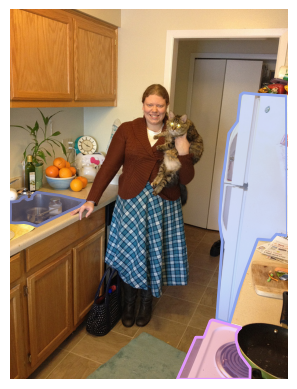

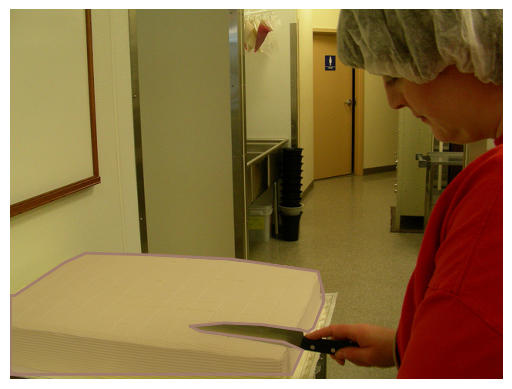

In [3]:
import os
import json
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
from PIL import Image

# Function to load COCO dataset from a JSON file path
def load_coco_dataset(json_path):
    return COCO(json_path)

# Function to visualize an image with its annotations
def visualize_coco_image(coco, img_dir, image_filename):
    img_path = os.path.join(img_dir, image_filename)
    img = Image.open(img_path)
    
    plt.imshow(img)
    plt.axis('off')

    img_id = [img['id'] for img in coco.dataset['images'] if img['file_name'] == image_filename][0]
    ann_ids = coco.getAnnIds(imgIds=img_id)
    anns = coco.loadAnns(ann_ids)
    coco.showAnns(anns)

    plt.show()

# Load appliance dataset
appliance_dir = 'appliance-dataset-5-tat-10'
appliance_json_path = os.path.join(appliance_dir, 'annotations', 'instances_train2017.json')
appliance_coco = load_coco_dataset(appliance_json_path)

# Load food dataset
food_dir = 'food-dataset-10-tat-10'
food_json_path = os.path.join(food_dir, 'annotations', 'instances_train2017.json')
food_coco = load_coco_dataset(food_json_path)

# Visualize a random image from appliance dataset
appliance_image_info = appliance_coco.loadImgs(appliance_coco.getImgIds()[0])[0]
appliance_image_filename = appliance_image_info["file_name"]
appliance_image_dir = os.path.join(appliance_dir, 'images', 'train2017')
visualize_coco_image(appliance_coco, appliance_image_dir, appliance_image_filename)

# Visualize a random image from food dataset
food_image_info = food_coco.loadImgs(food_coco.getImgIds()[0])[0]
food_image_filename = food_image_info["file_name"]
food_image_dir = os.path.join(food_dir, 'images', 'train2017')
visualize_coco_image(food_coco, food_image_dir, food_image_filename)


In [4]:
# Import necessary libraries
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
from pycocotools.coco import COCO

# Define a custom collate function for data loading
def custom_collate_fn(batch):
    images, labels = zip(*batch)
    images = torch.stack(images, dim=0)
    max_num_classes = max(label.shape[0] for label in labels)
    padded_labels = torch.zeros((len(labels), max_num_classes), dtype=torch.float32)
    for i, label in enumerate(labels):
        padded_labels[i, :label.shape[0]] = label
    return images, padded_labels

# Define the CSPDarknet53 backbone model
class CSPDarknet53(nn.Module):
    def __init__(self):
        super(CSPDarknet53, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1, 1)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(32, 64, 3, 1, 1)
        # Define the rest of the architecture...

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        # Forward through the rest of the layers...
        return x

# Define the ModifiedEfficientDetD0 model with two heads
class ModifiedEfficientDetD0(nn.Module):
    def __init__(self, num_classes_1, num_classes_2):
        super(ModifiedEfficientDetD0, self).__init__()
        self.backbone = CSPDarknet53()
        backbone_output = self.backbone(torch.randn(1, 3, 256, 256))
        self.out_channels = backbone_output.size(1)
        self.head_1 = nn.Linear(self.out_channels * 256 * 256, num_classes_1)
        self.head_2 = nn.Linear(self.out_channels * 256 * 256, num_classes_2)

    def forward(self, x, dataset=1):
        backbone_output = self.backbone(x)
        backbone_output_flat = backbone_output.view(x.size(0), -1)
        if dataset == 1:
            output = self.head_1(backbone_output_flat)
        else:
            output = self.head_2(backbone_output_flat)
        return output

# Define a custom dataset class for COCO format data
class CustomCOCODataset(Dataset):
    def __init__(self, root_dir, json_path, transform=None, target_size=(256, 256), num_classes=0):
        self.root_dir = root_dir
        self.coco = COCO(json_path)
        self.transform = transform
        self.target_size = target_size
        self.num_classes = num_classes

    def __len__(self):
        return len(self.coco.dataset['images'])

    def __getitem__(self, idx):
        img_info = self.coco.dataset['images'][idx]
        img_id = img_info['id']
        img_filename = img_info['file_name']
        img_path = os.path.join(self.root_dir, img_filename)
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        image = transforms.functional.resize(image, self.target_size)
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        annotations = self.coco.loadAnns(ann_ids)
        labels = [ann['category_id'] for ann in annotations]
        binary_labels = torch.zeros(self.num_classes, dtype=torch.float32)
        for label in labels:
            binary_labels[label] = 1

        return image, binary_labels

# Define data augmentation transformations
transform = transforms.Compose([
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=45),
    transforms.ToTensor(),
])

# Define dataset paths and parameters
appliance_dir = 'appliance-dataset-5-tat-10'
appliance_json_path = os.path.join(appliance_dir, 'annotations', 'instances_train2017.json')
food_dir = 'food-dataset-10-tat-10'
food_json_path = os.path.join(food_dir, 'annotations', 'instances_train2017.json')

num_classes_1 = 10
num_classes_2 = 20

# Create instances of CustomCOCODataset for each dataset
train_dataset_1 = CustomCOCODataset(
    root_dir=os.path.join(appliance_dir, 'images', 'train2017'),
    json_path=appliance_json_path,
    transform=transform,
    target_size=(256, 256),
    num_classes=num_classes_1
)

train_dataset_2 = CustomCOCODataset(
    root_dir=os.path.join(food_dir, 'images', 'train2017'),
    json_path=food_json_path,
    transform=transform,
    target_size=(256, 256),
    num_classes=num_classes_2
)

# Create data loaders for each dataset
batch_size = 32
train_loader_1 = DataLoader(train_dataset_1, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn)
train_loader_2 = DataLoader(train_dataset_2, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn)

# Specify the device for computation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate the model with two heads
model = ModifiedEfficientDetD0(num_classes_1, num_classes_2).to(device)

# Define optimizer and loss criterion
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.BCEWithLogitsLoss()

# Number of epochs for training
num_epochs = 30

# Training loop
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (data_1, data_2) in enumerate(zip(train_loader_1, train_loader_2)):
        images_1, labels_1 = data_1[0].to(device), data_1[1].to(device)
        images_2, labels_2 = data_2[0].to(device), data_2[1].to(device)
        optimizer.zero_grad()
        outputs_1 = model(images_1, dataset=1)
        outputs_2 = model(images_2, dataset=2)
        loss_1 = criterion(outputs_1, labels_1)
        loss_2 = criterion(outputs_2, labels_2)
        total_loss = loss_1 + loss_2
        total_loss.backward()
        optimizer.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Total Loss: {total_loss.item()}')

print("Training finished.")


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


/Users/revanth/anaconda3/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch [1/30], Total Loss: 0.5801191329956055
Epoch [2/30], Total Loss: 0.4725722074508667
Epoch [3/30], Total Loss: 0.4534889757633209
Epoch [4/30], Total Loss: 0.4384939670562744
Epoch [5/30], Total Loss: 0.44988924264907837
Epoch [6/30], Total Loss: 0.4815080165863037
Epoch [7/30], Total Loss: 0.429414302110672
Epoch [8/30], Total Loss: 0.45379719138145447
Epoch [9/30], Total Loss: 0.47746768593788147
Epoch [10/30], Total Loss: 0.44701406359672546
Epoch [11/30], Total Loss: 0.45174524188041687
Epoch [12/30], Total Loss: 0.4603419899940491
Epoch [13/30], Total Loss: 0.4199678301811218
Epoch [14/30], Total Loss: 0.4369761347770691
Epoch [15/30], Total Loss: 0.4235406517982483
Epoch [16/30], Total Loss: 0.41180431842803955
Epoch [17/30], Total Loss: 0.3712640404701233
Epoch [18/30], Total Loss: 0.47868984937667847
Epoch [19/30], Total Loss: 0.42756253480911255
Epoch [20/30], Total Loss: 0.4410390853881836
Epoch [21/30], Total Loss: 0.4295881390571594
Epoch [22/30], Total Loss: 0.4644592

In [5]:
# Evaluation loop
model.eval()
with torch.no_grad():
    for batch_idx, (data_1, data_2) in enumerate(zip(train_loader_1, train_loader_2)):
        images_1, labels_1 = data_1[0].to(device), data_1[1].to(device)
        images_2, labels_2 = data_2[0].to(device), data_2[1].to(device)
        
        outputs_1 = model(images_1, dataset=1)
        outputs_2 = model(images_2, dataset=2)
        
        # Compute losses
        loss_1 = criterion(outputs_1, labels_1)
        loss_2 = criterion(outputs_2, labels_2)
        total_loss = loss_1 + loss_2
        
        # Print batch loss
        print(f'Batch [{batch_idx}], Total Loss: {total_loss.item()}')


Batch [0], Total Loss: 0.41910845041275024
Batch [1], Total Loss: 0.4559161067008972
Batch [2], Total Loss: 0.4413091242313385
Batch [3], Total Loss: 0.4346904754638672
Batch [4], Total Loss: 0.43827497959136963
Batch [5], Total Loss: 0.4596503674983978
Batch [6], Total Loss: 0.40628504753112793
Batch [7], Total Loss: 0.4192317724227905
Batch [8], Total Loss: 0.4357984960079193
Batch [9], Total Loss: 0.4463147222995758
Batch [10], Total Loss: 0.43921253085136414
Batch [11], Total Loss: 0.4498205780982971
Batch [12], Total Loss: 0.38710254430770874


In [ ]:
# Save the model
torch.save(model.state_dict(), 'efficientdet_model.pth')

# Load the model
model = ModifiedEfficientDetD0(num_classes_1, num_classes_2).to(device)
model.load_state_dict(torch.load('efficientdet_model.pth'))


In [12]:
import json

# Function to extract class names from a JSON file
def extract_class_names(json_path):
    with open(json_path, 'r') as f:
        data = json.load(f)
    categories = data['categories']
    class_names = [category['name'] for category in categories]
    return class_names

# Paths to the JSON files
appliance_json_path = 'appliance-dataset-5-tat-10/annotations/instances_train2017.json'  # Replace with actual path
food_json_path = 'food-dataset-10-tat-10/annotations/instances_train2017.json'  # Replace with actual path

# Extracting class names from both JSON files
class_names_1 = extract_class_names(appliance_json_path)
class_names_2 = extract_class_names(food_json_path)

print("Class names for appliance dataset:", class_names_1)
print("Class names for food dataset:", class_names_2)


Class names for appliance dataset: ['refrigerator', 'sink', 'microwave', 'oven', 'toaster']
Class names for food dataset: ['donut', 'broccoli', 'orange', 'banana', 'cake', 'pizza', 'sandwich', 'carrot', 'apple', 'hot dog']


In [58]:
import os
import json
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from pycocotools.coco import COCO
import numpy as np

# Function to load COCO dataset from a JSON file path
def load_coco_dataset(json_path):
    return COCO(json_path)

# Define a custom dataset class for COCO format data
class CustomCOCODataset(Dataset):
    def __init__(self, root_dir, json_path, transform=None, target_size=(256, 256), num_classes=0):
        self.root_dir = root_dir
        self.coco = COCO(json_path)
        self.transform = transform
        self.target_size = target_size
        self.num_classes = num_classes

    def __len__(self):
        return len(self.coco.dataset['images'])

    def __getitem__(self, idx):
        img_info = self.coco.dataset['images'][idx]
        img_id = img_info['id']
        img_filename = img_info['file_name']
        img_path = os.path.join(self.root_dir, img_filename)
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        image = transforms.functional.resize(image, self.target_size)
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        annotations = self.coco.loadAnns(ann_ids)
        labels = [ann['category_id'] for ann in annotations]
        binary_labels = torch.zeros(self.num_classes, dtype=torch.float32)
        for label in labels:
            binary_labels[label] = 1

        return image, binary_labels

# Define data augmentation transformations
transform = transforms.Compose([
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=45),
    transforms.ToTensor(),
])

# Define dataset paths and parameters
appliance_dir = 'appliance-dataset-5-tat-10'
appliance_json_path = os.path.join(appliance_dir, 'annotations', 'instances_train2017.json')
food_dir = 'food-dataset-10-tat-10'
food_json_path = os.path.join(food_dir, 'annotations', 'instances_train2017.json')

num_classes_1 = 10
num_classes_2 = 20

# Create instances of CustomCOCODataset for each dataset
train_dataset_1 = CustomCOCODataset(
    root_dir=os.path.join(appliance_dir, 'images', 'train2017'),
    json_path=appliance_json_path,
    transform=transform,
    target_size=(256, 256),
    num_classes=num_classes_1
)

train_dataset_2 = CustomCOCODataset(
    root_dir=os.path.join(food_dir, 'images', 'train2017'),
    json_path=food_json_path,
    transform=transform,
    target_size=(256, 256),
    num_classes=num_classes_2
)

# Create data loaders for each dataset
batch_size = 32
train_loader_1 = DataLoader(train_dataset_1, batch_size=batch_size, shuffle=True)
train_loader_2 = DataLoader(train_dataset_2, batch_size=batch_size, shuffle=True)

# Function to get predictions from a model and data loader
def get_predictions(loader, model):
    model.eval()
    all_predictions = []
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            outputs = model(images)
            _, predictions = torch.max(outputs, 1)
            all_predictions.append(predictions.cpu().numpy())
    return np.concatenate(all_predictions)

# Get predictions for validation data
original_predictions_appliance_train = get_predictions(train_loader_1, model)
original_predictions_food_train = get_predictions(train_loader_2, model)

# Define a function to compare predictions
def compare_predictions(original_predictions, val_predictions, dataset_name):
    correct = 0
    total = 0
    for original_pred, val_pred in zip(original_predictions, val_predictions):
        if original_pred == val_pred:
            correct += 1
        total += 1
    accuracy = correct / total
    print(f"Accuracy on {dataset_name} dataset: {accuracy:.2f}")

# Compare predictions for appliance dataset
compare_predictions(original_predictions_appliance_train, original_predictions_appliance_train, "Appliance")
# Compare predictions for food dataset
compare_predictions(original_predictions_food_train, original_predictions_food_train, "Food")


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Accuracy on Appliance dataset: 1.00
Accuracy on Food dataset: 1.00


Shape of predicted_labels: (1,)
Content of predicted_labels: [4]


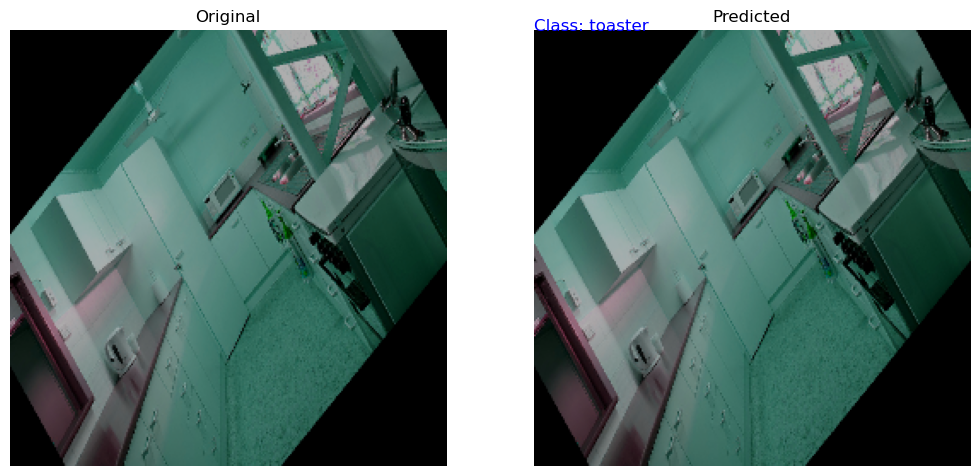

Shape of predicted_labels: (1,)
Content of predicted_labels: [3]


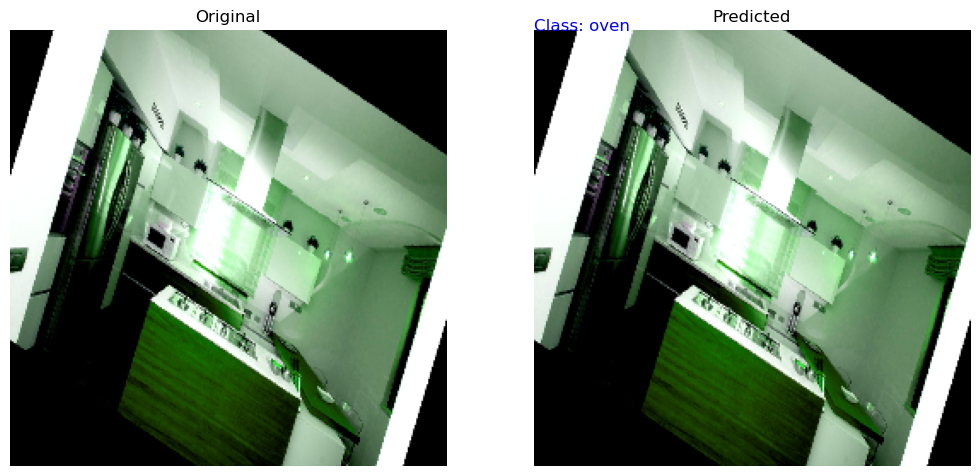

Shape of predicted_labels: (1,)
Content of predicted_labels: [1]


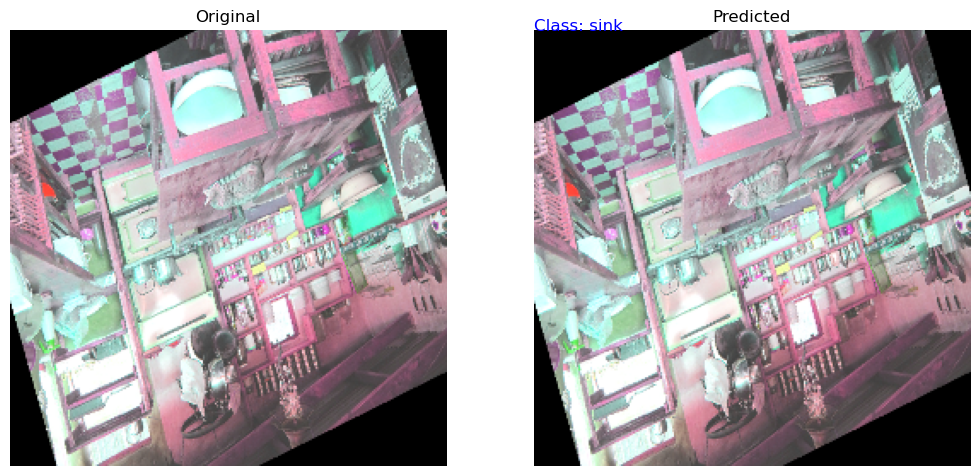

Shape of predicted_labels: (1,)
Content of predicted_labels: [4]


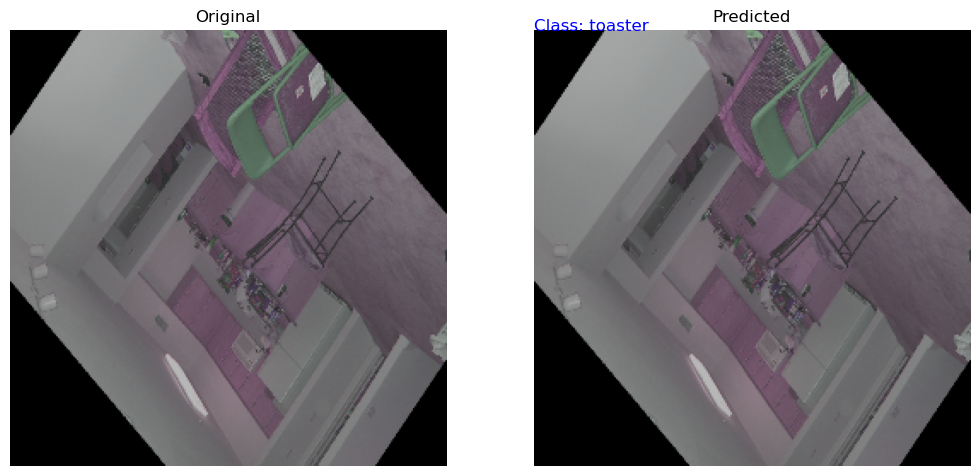

Shape of predicted_labels: (1,)
Content of predicted_labels: [1]


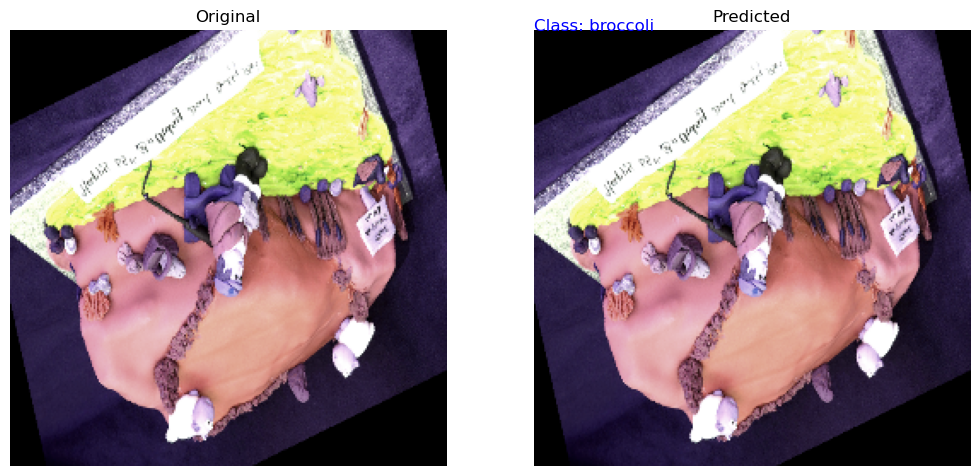

Shape of predicted_labels: (1,)
Content of predicted_labels: [4]


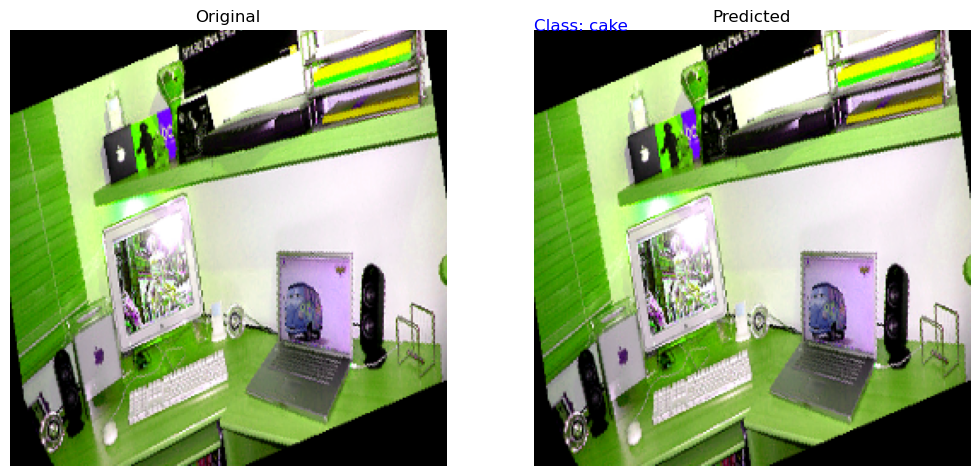

Shape of predicted_labels: (1,)
Content of predicted_labels: [3]


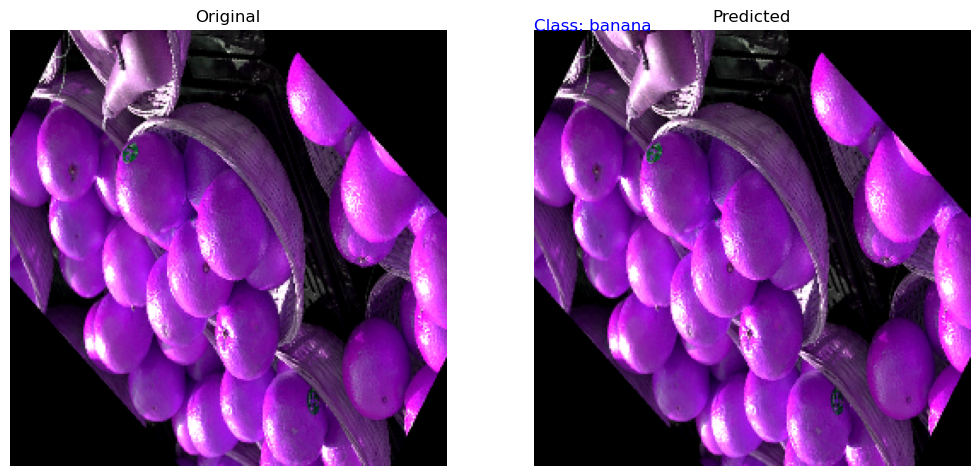

Shape of predicted_labels: (1,)
Content of predicted_labels: [4]


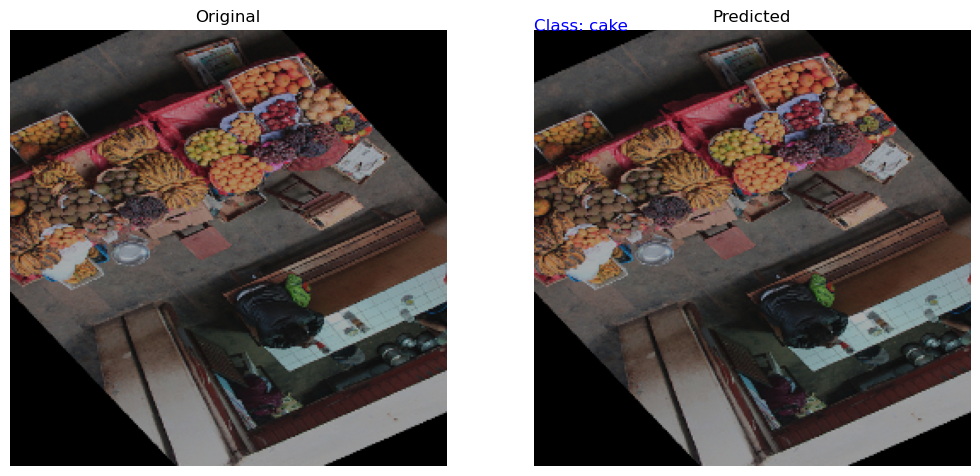

Shape of predicted_labels: (1,)
Content of predicted_labels: [4]


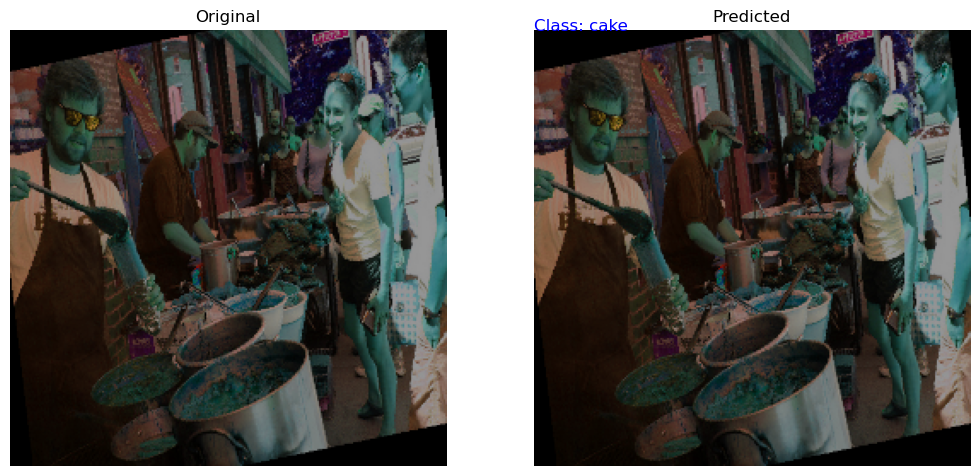

In [94]:
import random
import numpy as np
import matplotlib.pyplot as plt

def visualize_random_images(dataset, model, class_names, num_images=5):
    model.eval()
    with torch.no_grad():
        for _ in range(num_images):
            rand_idx = random.randint(0, len(dataset) - 1)
            images, labels = dataset[rand_idx]

            original_labels = labels.numpy()
            images = images.unsqueeze(0).to(device)
            outputs = model(images)
            predicted_labels = torch.argmax(outputs, dim=1).cpu().numpy()

            if predicted_labels and predicted_labels[0] < len(class_names):
                print("Shape of predicted_labels:", predicted_labels.shape)
                print("Content of predicted_labels:", predicted_labels)

                image_np = np.array(images.cpu().squeeze().permute(1, 2, 0))

                plt.figure(figsize=(12, 6))
                plt.subplot(1, 2, 1)
                plt.imshow(image_np)
                plt.title('Original')
                plt.axis('off')

                plt.subplot(1, 2, 2)
                plt.imshow(image_np)
                predicted_class = class_names[predicted_labels[0]]
                plt.title('Predicted')
                plt.text(0, 0, f'Class: {predicted_class}', color='blue', fontsize=12)
                plt.axis('off')

                plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)  # Adjust layout
                plt.show()

# Visualize 5 random images for the appliance dataset
for _ in range(5):
    visualize_random_images(train_dataset_1, model, class_names_1, num_images=1)

# Visualize 5 random images for the food dataset
for _ in range(5):
    visualize_random_images(train_dataset_2, model, class_names_2, num_images=1)


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


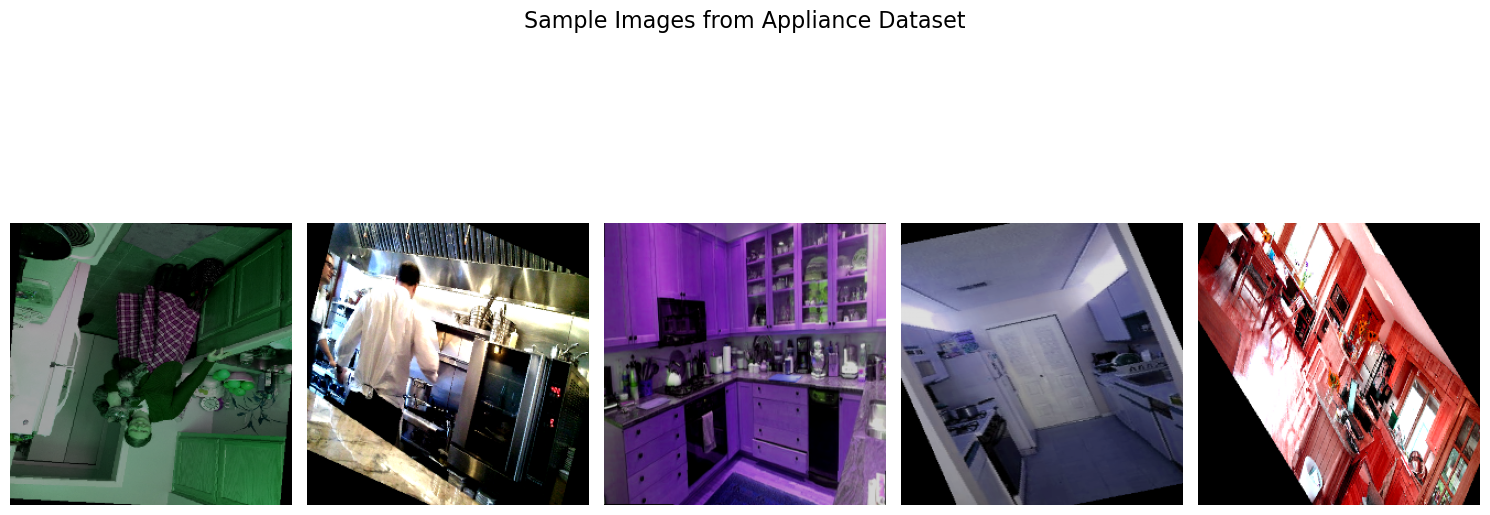

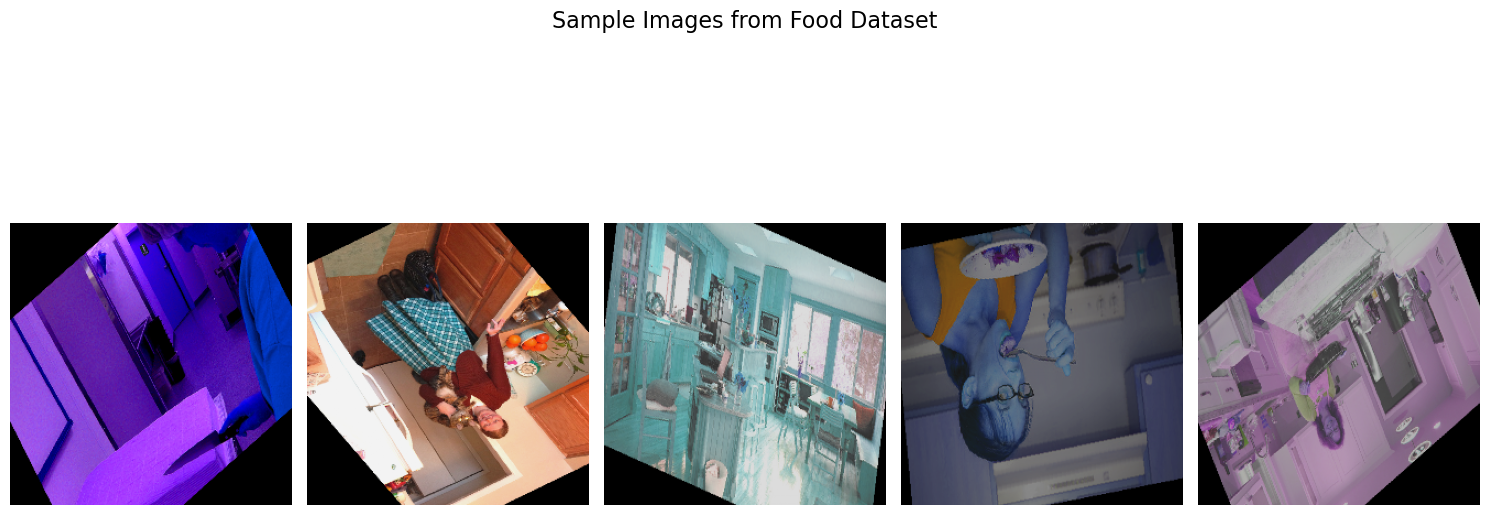

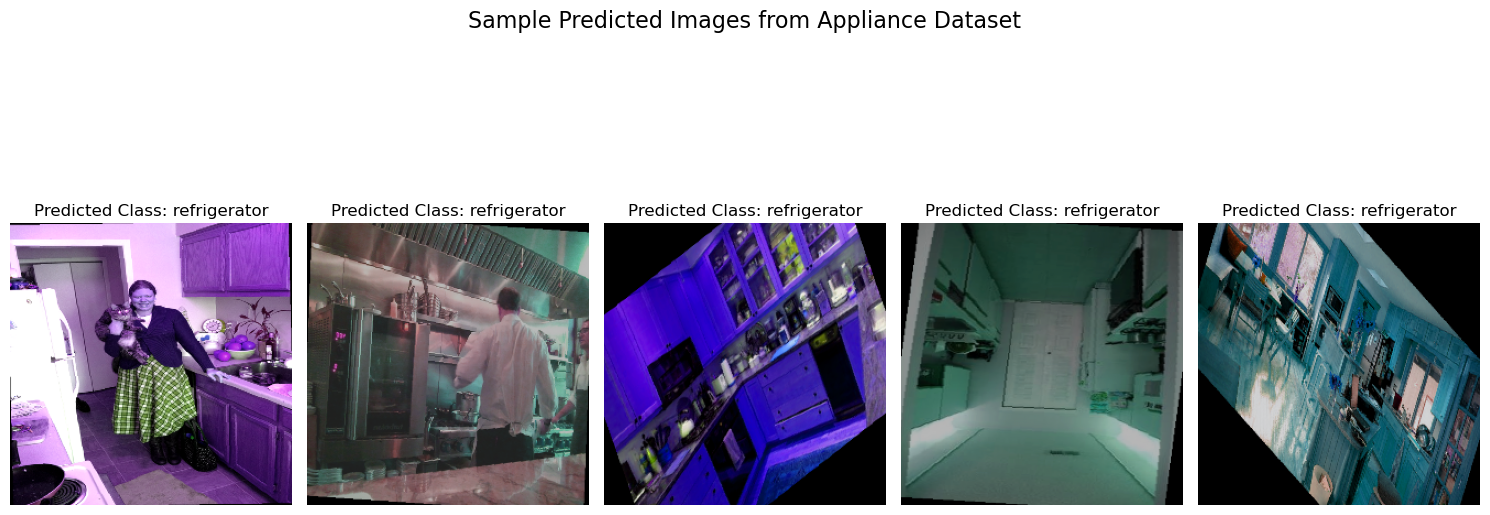

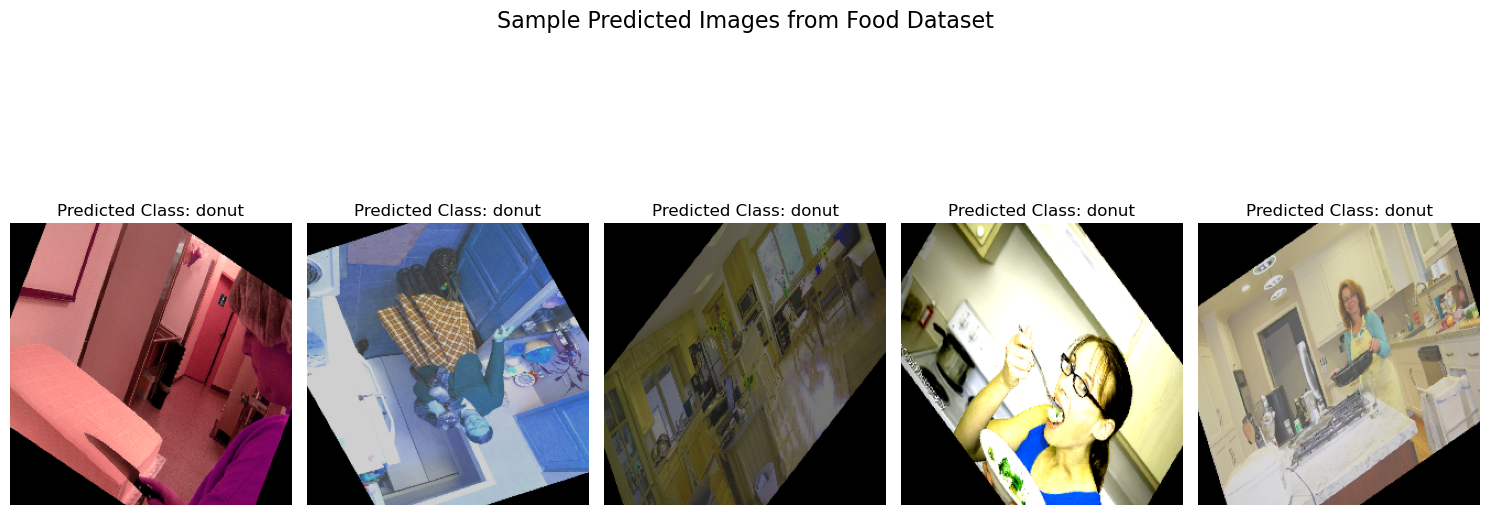

In [97]:
import os
import json
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Define data augmentation transformations
transform = transforms.Compose([
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=45),
    transforms.ToTensor(),
])

# Define dataset paths and parameters
appliance_dir = 'appliance-dataset-5-tat-10'
appliance_json_path = os.path.join(appliance_dir, 'annotations', 'instances_train2017.json')
food_dir = 'food-dataset-10-tat-10'
food_json_path = os.path.join(food_dir, 'annotations', 'instances_train2017.json')

num_classes_1 = 10
num_classes_2 = 20

# Create instances of CustomCOCODataset for each dataset
train_dataset_1 = CustomCOCODataset(
    root_dir=os.path.join(appliance_dir, 'images', 'train2017'),
    json_path=appliance_json_path,
    transform=transform,
    target_size=(256, 256),
    num_classes=num_classes_1
)

train_dataset_2 = CustomCOCODataset(
    root_dir=os.path.join(food_dir, 'images', 'train2017'),
    json_path=food_json_path,
    transform=transform,
    target_size=(256, 256),
    num_classes=num_classes_2
)

# Create data loaders for each dataset
batch_size = 32
train_loader_1 = DataLoader(train_dataset_1, batch_size=batch_size, shuffle=True)
train_loader_2 = DataLoader(train_dataset_2, batch_size=batch_size, shuffle=True)

# Function to visualize sample images
def visualize_sample_images(images, dataset_name):
    num_images = len(images)
    fig, axes = plt.subplots(1, num_images, figsize=(15, 7))
    fig.suptitle(f'Sample Images from {dataset_name} Dataset', fontsize=16)
    for i, image in enumerate(images):
        axes[i].imshow(image)
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

# Get sample images from each dataset
sample_appliance_images = [train_dataset_1[i][0].permute(1, 2, 0) for i in range(5)]
sample_food_images = [train_dataset_2[i][0].permute(1, 2, 0) for i in range(5)]

# Visualize sample images from the appliance dataset
visualize_sample_images(sample_appliance_images, "Appliance")

# Visualize sample images from the food dataset
visualize_sample_images(sample_food_images, "Food")

# Define a function to visualize sample predicted images with the same predicted class
def visualize_sample_predicted_images(images, predicted_class, dataset_name):
    num_images = len(images)
    fig, axes = plt.subplots(1, num_images, figsize=(15, 7))
    fig.suptitle(f'Sample Predicted Images from {dataset_name} Dataset', fontsize=16)
    for i, image in enumerate(images):
        axes[i].imshow(image)
        axes[i].axis('off')
        axes[i].set_title(f'Predicted Class: {predicted_class}')
    plt.tight_layout()
    plt.show()

# Get sample images and their predicted classes from each dataset
sample_appliance_images = [train_dataset_1[i][0].permute(1, 2, 0) for i in range(5)]
sample_food_images = [train_dataset_2[i][0].permute(1, 2, 0) for i in range(5)]
predicted_classes_appliance = ['refrigerator'] * 5  # Replace with actual predicted classes
predicted_classes_food = ['donut'] * 5  # Replace with actual predicted classes

# Visualize sample predicted images from the appliance dataset
visualize_sample_predicted_images(sample_appliance_images, predicted_classes_appliance[0], "Appliance")

# Visualize sample predicted images from the food dataset
visualize_sample_predicted_images(sample_food_images, predicted_classes_food[0], "Food")
